In [1]:
import os, json, sys
from itertools import izip
import numpy as np
import importlib
from spearmint.utils.database.mongodb import MongoDB
from spearmint.main import parse_resources_from_config, load_jobs, \
    remove_broken_jobs, load_task_group, load_hypers
from collections import OrderedDict
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import pymongo
%matplotlib inline

/home/lho/Htw/bachelor/thesis-code/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def get_options(dir_path):
    # Read in the config file
    expt_dir  = os.path.realpath(os.path.expanduser(dir_path))
    if not os.path.isdir(expt_dir):
        raise Exception("Cannot find directory %s" % expt_dir)
    expt_file = os.path.join(expt_dir, 'config.json')

    try:
        with open(expt_file, 'r') as f:
            options = json.load(f, object_pairs_hook=OrderedDict)
    except:
        raise Exception("config.json did not load properly. Perhaps a spurious comma?")
    options["config"]  = 'config.json'

    # Set sensible defaults for options
    options['chooser']  = options.get('chooser', 'default_chooser')
    if 'tasks' not in options:
        options['tasks'] = {'main' : {'type' : 'OBJECTIVE', 'likelihood' : options.get('likelihood', 'GAUSSIAN')}}

    if not os.path.exists(expt_dir):
        sys.stderr.write("Cannot find experiment directory '%s'. "
                         "Aborting.\n" % (expt_dir))
        sys.exit(-1)

    return options, expt_dir

In [3]:
def print_dict(d, level=1):
    if isinstance(d, dict):
        if level > 1: print ""
        for k, v in d.iteritems():
            print "  " * level, k,
            print_dict(v, level=level+1)
    else:
        print d 

In [4]:
options, ext_dir = get_options('../spearmint/metric-test/')

In [5]:
dba = options['database']['address']
dbn = options['database']['name']
experiment_name = options.get("experiment-name", 'unnamed-experiment')

In [63]:
print experiment_name

metric-test


In [8]:
db = MongoDB(database_address=dba, database_name=dbn)

In [9]:
jobs = load_jobs(db, experiment_name)
resources = parse_resources_from_config(options)
resource = resources.itervalues().next()

In [69]:
#db.db[experiment_name]['jobs'].drop()
#db.db[experiment_name]['hypers'].drop()

In [11]:
# Load up the chooser.
chooser_module = importlib.import_module('spearmint.choosers.' + options['chooser'])
chooser = chooser_module.init(options)
print "chooser", chooser

Not running from main.
Not running from main.
chooser <spearmint.choosers.default_chooser.DefaultChooser object at 0x7ff83c8f0b10>


In [12]:
task_options = { task: options["tasks"][task] for task in resource.tasks }
print "task_options:"
print_dict(task_options) # {'main': {'likelihood': u'NOISELESS', 'type': 'OBJECTIVE'}}

task_options:
   main 
     likelihood NOISELESS
     type OBJECTIVE


In [13]:
task_group = load_task_group(db, options, resource.tasks)
print "task_group", task_group # TaskGroup
print "tasks:"
print_dict(task_group.tasks)

task_group <spearmint.tasks.task_group.TaskGroup object at 0x7ff822142fd0>
tasks:
   main <spearmint.tasks.task.Task object at 0x7ff822142b90>


In [14]:
hypers = load_hypers(db, experiment_name)
print "loaded hypers", hypers

loaded hypers {u'main': {u'chain length': 230, u'hypers': {u'amp2': 1.1798462549861126, u'beta_alpha': array([ 0.90550012,  0.66540298,  9.6609684 ]), u'ls': array([  8.33613196e+00,   9.47574001e+00,   2.69236282e-03]), u'beta_beta': array([ 3.7437587 ,  0.14578731,  4.70471854]), u'mean': 0.8152653241701124}}, u'_id': ObjectId('569e84a4ba36a6b4286c5cfb')}


In [15]:
hypers = chooser.fit(task_group, hypers, task_options)
print "\nfitted hypers:"
print_dict(hypers)


fitted hypers:
   main 
     chain length 240
     hypers 
       amp2 0.756436727876
       beta_alpha [ 0.259176    0.19333858  9.11694452]
       ls [  6.53378871e+00   8.79886919e+00   4.36602254e-03]
       beta_beta [ 0.48319759  0.92089487  4.49793957]
       mean 0.264280925915


Fitting GP for main task...


In [16]:
lp, x = chooser.best()
x = x.flatten()
print "best", lp, x
bestp = task_group.paramify(task_group.from_unit(x))
print "expected best position", bestp

best -0.738225498009 [ 0.53125  0.03125  0.40625]
expected best position {u'n_hidden_layer': {'values': array([ 83.]), 'type': u'int'}, u'eta': {'values': array([ 0.0465625]), 'type': u'float'}, u'border': {'values': array([ 4.]), 'type': u'int'}}



Minimum expected objective value under model is -0.00248 (+/- 0.00982), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                n_hidden_lay  int        83          
                eta           float      0.046563    
                border        int        4           

Minimum of observed values is 0.000798, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                n_hidden_lay  int        80          
                eta           float      0.010000    
                border        int        2           


In [79]:
# get the grid of points
grid = chooser.grid
#     print "chooser objectives:", 
#     print_dict(chooser.objective)
print "chooser models:", chooser.models
print_dict(chooser.models)
obj_model = chooser.models[chooser.objective['name']]
obj_mean, obj_var = obj_model.function_over_hypers(obj_model.predict, grid)

chooser models: {'main': <spearmint.models.gp.GP object at 0x7fc1a480ee90>}
   main <spearmint.models.gp.GP object at 0x7fc1a480ee90>


In [80]:
grid

array([[ 0.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.75      ,  0.25      ],
       ..., 
       [ 0.5430848 ,  0.1512512 ],
       [ 0.54309733,  0.15102969],
       [ 0.54288707,  0.15140965]])

In [62]:
# un-normalize the function values and variances
obj_task = task_group.tasks['main']
obj_mean = [obj_task.unstandardize_mean(obj_task.unstandardize_variance(v)) for v in obj_mean]
obj_std = [obj_task.unstandardize_variance(np.sqrt(v)) for v in obj_var]

In [82]:
grid = map(task_group.from_unit, grid)

In [70]:
xymv = [(xy[0], xy[1], m, v) for xy, m, v in izip(grid, obj_mean, obj_std)]# if .2 < xy[0] < .25] 

In [73]:
x = map(lambda x:x[0], xymv)
y = map(lambda x:x[1], xymv)
m = map(lambda x:x[2], xymv)
sig = map(lambda x:x[3], xymv)

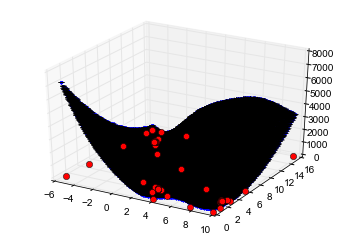

In [76]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, m, marker='.', linestyle="None")

# plot errorbars
for i in np.arange(0, len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [m[i]+sig[i], m[i]-sig[i]], marker="_", color='k')

# get the observed points
task = task_group.tasks['main']
idata = task.valid_normalized_data_dict
xy = idata["inputs"]
xy = map(task_group.from_unit, xy)
xy = np.array(xy)
vals = idata["values"]
vals = [obj_task.unstandardize_mean(obj_task.unstandardize_variance(v)) for v in vals]

ax.plot(xy[:,0], xy[:,1], vals, marker='o', color="r", linestyle="None")
    
plt.show()